# RoBERTa Pretrained Sequence Classifier

In [1]:
import numpy as np
import pandas as pd
import torch
from IPython.display import clear_output
from torch import nn, optim, cuda
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaConfig, RobertaForMultipleChoice
from transformers import AdamW, get_scheduler
from datetime import datetime
import matplotlib.pyplot as plt
device = torch.device('cuda' if cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

cuda


In [2]:
# def fix_data(file_xml, file_json):
#     df_xml = pd.read_xml(file_xml)
#     df_xml['most-plausible-alternative'] = df_xml['most-plausible-alternative'] - 1
#     df_json = df_xml.rename(columns={'id': 'idx', 'asks-for': 'question',
#                              'most-plausible-alternative': 'label','p': 'premise', 
#                              'a1': 'choice1', 'a2': 'choice2'})
#     df_json.to_json(file_json, orient='records', lines=True)

In [3]:
# fix_data('data/COPA-resources/datasets/copa-dev-fixed.xml', 
#          'data/COPA-resources/datasets/copa-dev-fixed.jsonl')
# fix_data('data/COPA-resources/datasets/copa-test.xml', 
#          'data/COPA-resources/datasets/copa-test.jsonl')

In [4]:
class CopaDatasetMoreData(Dataset):
    def __init__(self, filename):
        super().__init__()
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        
        with open(filename, 'r', encoding='utf8') as file:
            raw_data = pd.read_json(file, lines=True)
        self.data = []
        self.masks = []
        self.labels = []
            
        prompts = []
        choices = []
        for i, row in raw_data.iterrows():
            prompts.append(row['question'] + row['premise'])
            prompts.append(row['question'] + row['premise'])
            choices.append(row['choice1'])
            choices.append(row['choice2'])
            self.labels.append(row['label'])
        
        tokenized = self.tokenizer(prompts, choices, return_tensors='pt',
                                   padding=True, truncation=True)
        
        for i in range(int(len(tokenized['input_ids']) / 2)):
            idx = 2 * i
            self.data.append(torch.stack([tokenized['input_ids'][idx], 
                                          tokenized['input_ids'][idx + 1]]))
            self.masks.append(torch.stack([tokenized['attention_mask'][idx], 
                                           tokenized['attention_mask'][idx + 1]]))
        
    def __len__(self):
        return len(self.data)
    
    def clear(self):
        for elt in self.data:
            del elt
        for elt in self.masks:
            del elt
        for elt in self.labels:
            del elt
        torch.cuda.empty_cache()
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        return ([self.data[idx].to(device), 
                 self.masks[idx].to(device)]), torch.tensor(self.labels[idx], device=device)

In [5]:
# train_data = CopaDatasetMoreData('data/COPA-resources/datasets/copa-test.jsonl')
# train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
# print(f'Training data loaded (length {len(train_data)})')
# dev_data = CopaDatasetMoreData('data/COPA-resources/datasets/copa-dev-fixed.jsonl')
# dev_dataloader = DataLoader(dev_data, batch_size=50, shuffle=True)
# print(f'Dev data loaded (length {len(dev_data)})')
torch.manual_seed(3832)
all_data = CopaDatasetMoreData('data/COPA-resources/datasets/copa-all.jsonl')
train_data, dev_data = torch.utils.data.random_split(all_data, [800, 100])
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
dev_dataloader = DataLoader(dev_data, batch_size=8, shuffle=True)

In [6]:
config = RobertaConfig.from_pretrained('roberta-base', num_labels=2)

## Training

In [7]:
# initialize model
teacup = RobertaForMultipleChoice(config)
teacup.to(device)
torch.cuda.empty_cache()

# 3) Now we train our model
start_time = datetime.now()
epochs = 4
report_per = 1

# optimizer & LR decay scheduler
optimizer = AdamW(teacup.parameters(), lr=1e-3)
num_training_steps = epochs * len(train_dataloader)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lr_scheduler = get_scheduler(
    "polynomial",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

dev_acc = np.zeros(epochs // report_per)
train_acc = np.zeros(epochs // report_per)

print('Beginning training loop')
for i in range(epochs):
        
    if i % report_per == 0:
        print('### Epoch: ' + str(i+1) + ' ###')

#     train_data, dev_data = torch.utils.data.random_split(all_data, [800, 100])
#     train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)
#     dev_dataloader = DataLoader(dev_data, batch_size=20, shuffle=True)
        
    # train loop
    teacup.train()
    for batch in train_dataloader:
        # get batch predictions
        (X, mask), y = batch
        out = teacup(input_ids=X, attention_mask=mask, labels=y)
        
        # backpropagate loss
        out.loss.backward()

        # update weights
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # record train acc
        if (i + 1) % report_per == 0:
            train_acc[i // report_per] += float(torch.sum(torch.argmax(out.logits, dim=1) == y))
            
        del out
        
    del X
    del mask
    del y
    
    # validate
    if (i + 1) % report_per == 0:
        teacup.eval()
        with torch.no_grad():
            for batch in dev_dataloader:
                (X, mask), y = batch
                out = teacup(input_ids=X, attention_mask=mask, labels=y)
                dev_acc[i // report_per] += float(torch.sum(torch.argmax(out.logits, dim=1) == y))
                
            dev_acc[i // report_per] /= len(dev_data)
            train_acc[i // report_per] /= len(train_data)
            
        epoch_time = datetime.now() - start_time
        clear_output(wait=True)
        print(f'Epoch {i + 1} complete in {str(epoch_time)};',
              f'est. finish at {str(start_time + (epoch_time / (i + 1) * epochs))}')
        print(f'Validation: {train_acc[i // report_per]} train | {dev_acc[i // report_per]} dev')
        
end_time = datetime.now()
print(f'Training completed in {str(end_time - start_time)}')

Epoch 4 complete in 0:02:23.160366; est. finish at 2021-11-30 15:54:12.610550
Validation: 0.5025 train | 0.42 dev
Training completed in 0:02:23.160366


## Results

In [6]:
dev_acc

array([0.66, 0.58, 0.54, 0.56, 0.54, 0.6 , 0.58, 0.58, 0.62, 0.62])

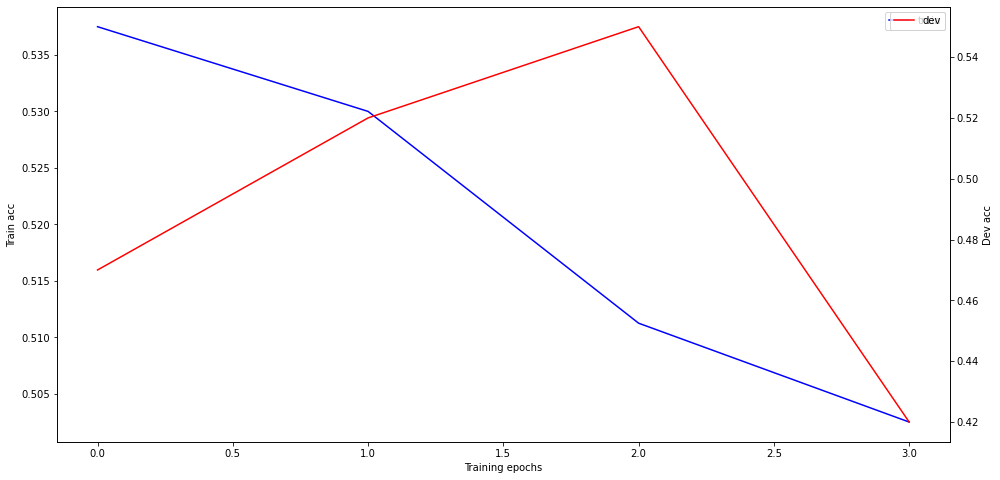

In [8]:
# BVT plot
fig, ax = plt.subplots(figsize=(16, 8))
ax2 = ax.twinx()
ax.plot(train_acc, label='train', color='blue')
ax2.plot(dev_acc, label='dev', color='red')

ax.legend()
ax2.legend()
ax.set_ylabel('Train acc')
ax2.set_ylabel('Dev acc')
ax.set_xlabel('Training epochs')
plt.show()

## External code for seq. classification

## Grid search/hyperparameter tuning

In [9]:
def train(train_dataloader, train_len, dev_dataloader, dev_len, epochs, report_per, lr, batch_size):
    
    # initialize model
    teacup = RobertaForMultipleChoice(RobertaConfig.from_pretrained('roberta-base', 
                                                                            num_labels=2))
    teacup.to(device)
    torch.cuda.empty_cache()

    # 3) Now we train our model. 
    start_time = datetime.now()

    # optimizer & LR decay scheduler
    optimizer = AdamW(teacup.parameters(), lr=lr)
    num_training_steps = epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(
        "polynomial",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    dev_acc = np.zeros(epochs // report_per)
    train_acc = np.zeros(epochs // report_per)

    print('Beginning training loop')
    for i in range(epochs):

        # train loop
        teacup.train()
        for batch in train_dataloader:
            # get batch predictions
            (X, mask), y = batch
            out = teacup(input_ids=X, attention_mask=mask, labels=y)

            # backpropagate loss
            out.loss.backward()

            # update weights
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # record train acc
            if (i + 1) % report_per == 0:
                train_acc[i // report_per] += float(torch.sum(torch.argmax(out.logits, dim=1) == y))

            del out

        del X
        del mask
        del y

        # validate
        if (i + 1) % report_per == 0:
            teacup.eval()
            with torch.no_grad():
                for batch in dev_dataloader:
                    (X, mask), y = batch
                    out = teacup(input_ids=X, attention_mask=mask, labels=y)
                    dev_acc[i // report_per] += float(torch.sum(torch.argmax(out.logits, dim=1) == y))

                dev_acc[i // report_per] /= dev_len
                train_acc[i // report_per] /= train_len

            epoch_time = datetime.now() - start_time
            clear_output(wait=True)
            print(f'Epoch {i + 1} complete in {str(epoch_time)};',
                  f'est. finish at {str(start_time + (epoch_time / (i + 1) * epochs))}')
            print(f'Validation: {train_acc[i // report_per]} train | {dev_acc[i // report_per]} dev')

    end_time = datetime.now()
    print(f'Training completed in {str(end_time - start_time)}')
    
    return dev_acc, train_acc

In [10]:
def grid_search(dev_accs, train_accs, epochs, report_per, lrs, batch_sizes):
    for batch_size in batch_sizes:
        
        # load data
        train_data = CopaDatasetMoreData('data/COPA-resources/datasets/copa-test.jsonl')
        train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        print(f'Training data loaded (length {len(train_data)})')
        dev_data = CopaDatasetMoreData('data/COPA-resources/datasets/copa-dev-fixed.jsonl')
        dev_dataloader = DataLoader(dev_data, batch_size=100, shuffle=True)
        print(f'Dev data loaded (length {len(dev_data)})')
        
        for lr in lrs:
            print(f'Training lr={lr}, batch size={batch_size}')
            dev_acc, train_acc = train(train_dataloader, len(train_data), 
                                       dev_dataloader, len(dev_data),
                                       epochs, report_per, 
                                       lr, batch_size)
            dev_accs[(lr, batch_size)] = dev_acc
            train_accs[(lr, batch_size)] = train_acc
                    
        train_data.clear()
        dev_data.clear()
        del train_data
        del dev_data
        del train_dataloader
        del dev_dataloader

In [11]:
# initialize grid search
lrs = [5e-5, 3e-5]
batch_sizes = [8, 16]
dev_accs = dict()
train_accs = dict()
grid_search(dev_accs, train_accs, 10, 2, lrs, batch_sizes)

Epoch 10 complete in 0:03:35.269843; est. finish at 2021-11-30 14:21:06.973916
Validation: 0.908 train | 0.545 dev
Training completed in 0:03:35.272843


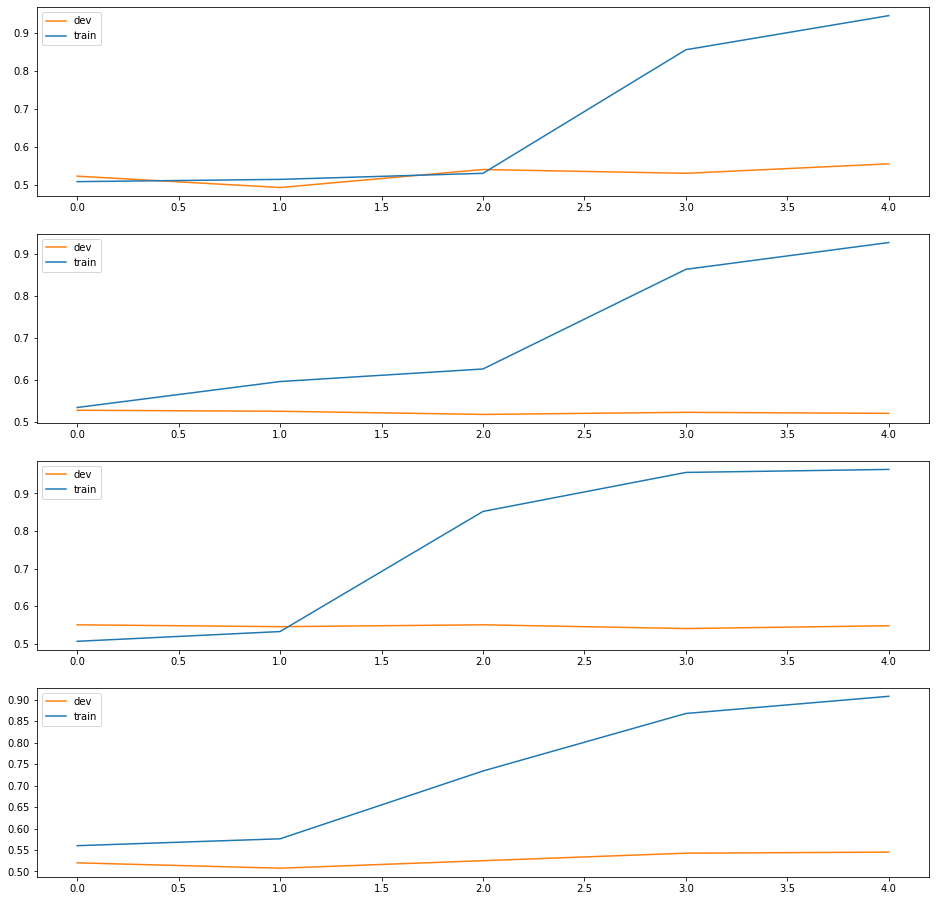

In [12]:
# new BVT plots
figs, axes = plt.subplots(nrows=4, figsize=(16, 16))
row_dict = {(5e-5, 8): 0, (3e-5, 8): 1, (5e-5, 16): 2, (3e-5, 16): 3}

for item in dev_accs:
    idx2 = row_dict[(item[0], item[1])]
    axes[idx2].plot(dev_accs[item], label='dev', color='tab:orange')
    axes[idx2].plot(train_accs[item], label='train', color='tab:blue')
    axes[idx2].legend()

In [11]:
dev_accs

{(5e-05, 8, 'linear'): array([0.38, 0.38, 0.38, 0.38, 0.4 ]),
 (5e-05, 8, 'polynomial'): array([0.52, 0.48, 0.5 , 0.48, 0.48]),
 (3e-05, 8, 'linear'): array([0.44, 0.48, 0.48, 0.48, 0.46]),
 (3e-05, 8, 'polynomial'): array([0.4 , 0.44, 0.4 , 0.42, 0.4 ]),
 (5e-05, 16, 'linear'): array([0.36, 0.4 , 0.46, 0.44, 0.42]),
 (5e-05, 16, 'polynomial'): array([0.38, 0.32, 0.34, 0.38, 0.34]),
 (3e-05, 16, 'linear'): array([0.58, 0.5 , 0.46, 0.46, 0.46]),
 (3e-05, 16, 'polynomial'): array([0.5 , 0.48, 0.48, 0.44, 0.48])}

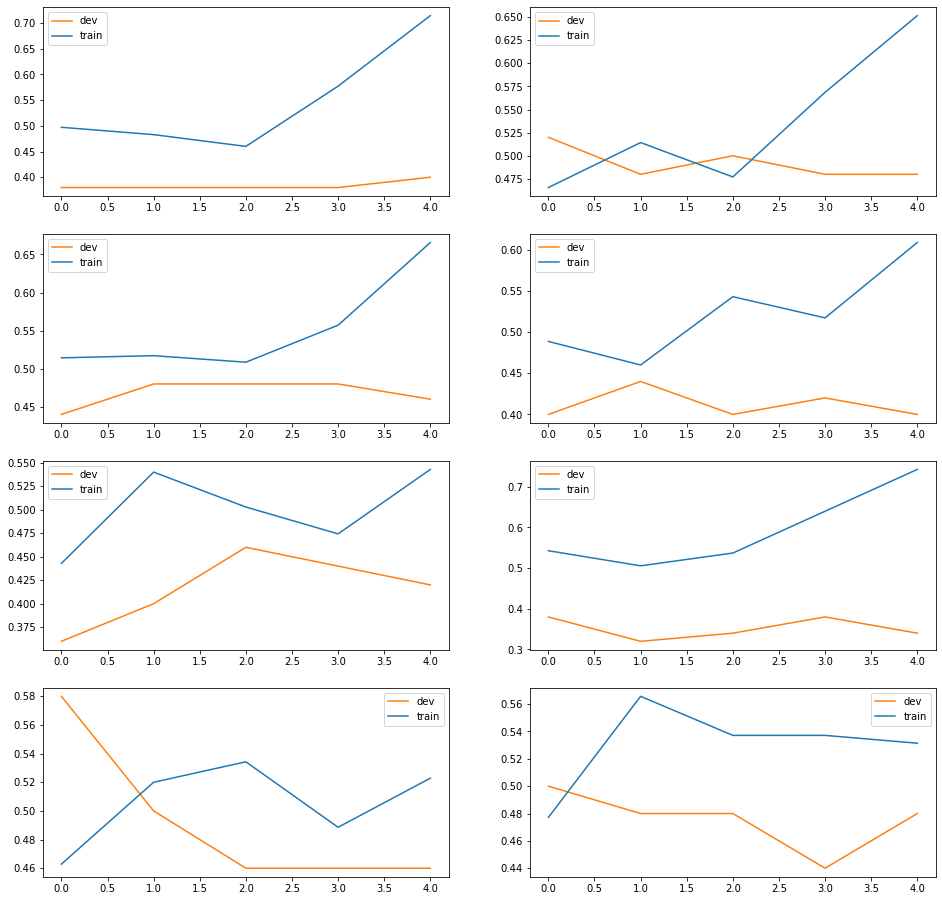

In [18]:
# old BVT plots
figs, axes = plt.subplots(ncols=2, nrows=4, figsize=(16, 16))
col_dict = {'linear': 0, 'polynomial': 1}
row_dict = {(5e-5, 8): 0, (3e-5, 8): 1, (5e-5, 16): 2, (3e-5, 16): 3}

for item in dev_accs:
    idx1 = col_dict[item[2]]
    idx2 = row_dict[(item[0], item[1])]
    axes[idx2][idx1].plot(dev_accs[item], label='dev', color='tab:orange')
    axes[idx2][idx1].plot(train_accs[item], label='train', color='tab:blue')
    axes[idx2][idx1].legend()